# MitoCheck

In [99]:
## Ipython magic commands...! 

%matplotlib inline
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [100]:
### All the packages we need:
from Traj_creator import Traj_data
from TCA import *
from Mitocheck_Read import MitoCheck_Read
from Randomforest import RandomForest_Autotunner,plot_matrix,Measure,check_rotate
from auxilary_function import final_classif_HMM,MitoseClassif,EmissionMat,prep_for_R

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os.path
import cPickle as pkl

In [101]:
## names for the variables
y_name_3state="Type"         #variable name of the labels in the training set
classif_Mitose="MitoseOrNot" #variable name for the mitosis variable
classif_3state="3state"      #variable name for the classifier we wish to test
classif_final="Pred_fusion"  #variable name for the fusion of these two classifiers
classif_hmm="HMM"            #variable name for the hmm corrector
num_str="0015" 
%Rpush classif_final classif_hmm

In [5]:
if os.path.isfile("H2B_N_F_0.csv"):
    print "The file existed so I loaded it."
    H2B_N_F_0 = Traj_data(file_name="H2B_N_F_0.csv",pkl_traj_file="./Pkl_file") 
    H2B_N_F_0.caract="Normalized by dividing by first element"

else:    
    H2B_N_F_0=Traj_data()#(pkl_traj_file="/home/pubuntu/Documents/InternWork2/Pkl_file") 

    H2B_N_F_0.extracting(num_str,"both_channels_0015.hdf5",'primary') 
    ## Extracting the hdf5 file for the primary channel (H2b)
    
#    H2B_N_.add_error() ## We had it so that the data won't have to do 0/0

    H2B_N_F_0.Add_traj(normalize=True,all_traj=False,average=False,diff=False)## ,num_traj=10) ## (you can reduce the number of traj)
    ## Adding Alice's work on tracking to have trajectories

    file_loc="0015_PCNA.xml"

    H2B_N_F_0.label_finder(file_loc) 
    ## Finding associated labels by minimizing distance by click and distance of cell

    H2B_N_F_0.renaming_and_merge() 
    ## renaming the labels to have G1=="1", S=="S", G2=="2" and M=="M" 
    #This procedure may take a long time.

    H2B_N_F_0.data.to_csv('H2B_N_F_0.csv',index=False,header=True)

    

if H2B_N_F_0.Var_missing[0] in H2B_N_F_0.train.columns:
    H2B_N_F_0.missing_features_train()
if H2B_N_F_0.Var_missing[0] in H2B_N_F_0.data.columns:
    H2B_N_F_0.missing_features_data()

    
    

The file existed so I loaded it.
Traj_data built
Reader constructed
Updated member Group_of_traj


/home/pubuntu/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:3006: DtypeWarning: Columns (245) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [102]:
MitoCheck = MitoCheck_Read()

if MitoCheck.Var_missing[0] in MitoCheck.data.columns:
    MitoCheck.missing_features()


MitoCheck_Read()
Updated member Group_of_traj


# Preparing the classifier and prediction:

## Mitose or Not?

### Training: 


 We first load the unnormalized data: 

The file existed so I loaded it.
Traj_data built
Reader constructed
Updated member Group_of_traj

 We train a classifier for mitosis or not: 

Reader constructed
Processing time: 246.932864 in sec


/home/pubuntu/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:3066: DtypeWarning: Columns (245) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


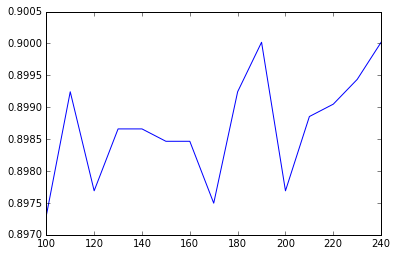

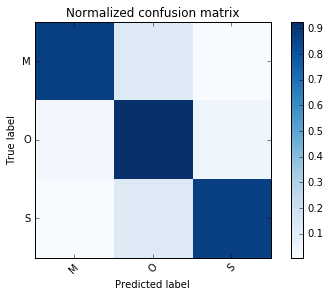

Updated member Group_of_traj
Updated member Group_of_traj

 A bit of statistics on the overall predictions: 

Frequency of predicted values for the Mitosis or not classifier: 

O    14854
S    14081
M      879
Name: MitoseOrNot, dtype: int64

 We were however not able to predict 0 instances because of missing values
Updated member Group_of_traj


In [7]:
H2B_N_F_0,model_1=MitoseClassif(H2B_N_F_0,
                                y_name_3state=y_name_3state,
                               classif_Mitose=classif_Mitose,
                               num_str=num_str)

### Predicting in MitoCheck dataset

In [103]:
MitoCheck.data=MitoCheck.data.replace([np.inf, -np.inf], np.nan)

instances_to_keep_Mito=MitoCheck.data.dropna(axis=0, how='any').index

print "Size of the data set: %d" %MitoCheck.data.shape[0]
print "Number of dropped values: %d" %(MitoCheck.data.shape[0]-len(instances_to_keep_Mito))

MitoCheck.data.ix[instances_to_keep_Mito,classif_Mitose]=model_1.predict(MitoCheck.data.ix[instances_to_keep_Mito,model_1.names_to_give])

print "A bit of descriptive statistic about the prediction on MitoCheck: \n"
MitoCheck.data[classif_Mitose].value_counts()

Size of the data set: 18557
Number of dropped values: 0
A bit of descriptive statistic about the prediction on MitoCheck: 



S    13727
O     4205
M      625
Name: MitoseOrNot, dtype: int64

## 3 State classifier

Updated member Group_of_traj
training dataset: 

S    217
1    199
2     56
M     36
Name: Type, dtype: int64
Processing time: 24.128684 in sec


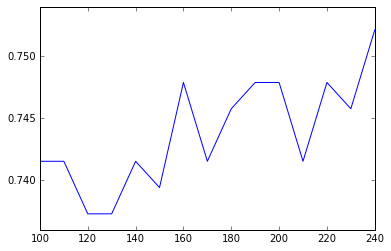

We now have a classifier with n=240, with an expected accuracy of 0.752 for the normalized data. 



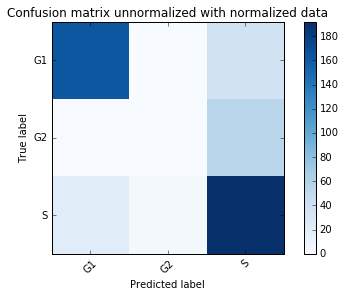

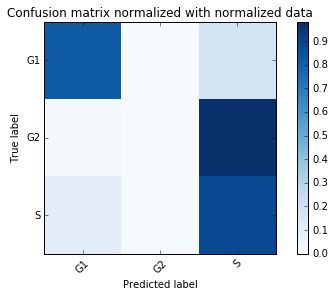

Frequency of predicted values for the 3 state classifier: 

1    15867
S    12714
2     1233
Name: 3state, dtype: int64


In [9]:
## classifier number 1

###
kfold=3

instances_to_keep=pd.notnull(H2B_N_F_0.data.traj)

H2B_N_F_0.data=H2B_N_F_0.data.ix[instances_to_keep,H2B_N_F_0.data.columns]

instances_to_change=H2B_N_F_0.data["Type"]!="M"

H2B_N_F_0.update()

print "training dataset: \n"
print H2B_N_F_0.train["Type"].value_counts()

values=[100 + i*10 for i in range(15)]
model_n_m=RandomForest_Autotunner(values)

model_n_m.tunning(H2B_N_F_0.train.ix[instances_to_change,H2B_N_F_0.names],H2B_N_F_0.train.ix[instances_to_change,"Type"],kfold,plot=True,fit_new_model=True)
plt.show()

i_=np.argmax(model_n_m.MSE)
n_tree=values[i_]
print "We now have a classifier with n=%d, with an expected accuracy of %5.3f for the normalized data. \n" %(n_tree,max(model_n_m.MSE))


plot_matrix(model_n_m.cm,title="Confusion matrix unnormalized with normalized data",names=["G1","G2","S"])
plt.show()
model_n_m.cm_normalized = model_n_m.cm.astype('float') / model_n_m.cm.sum(axis=1)[:, np.newaxis]
plot_matrix(model_n_m.cm_normalized,title="Confusion matrix normalized with normalized data",names=["G1","G2","S"])
plt.show() 

index_no_missing=H2B_N_F_0.data[H2B_N_F_0.names].dropna(axis=0, how='any').index
H2B_N_F_0.data.ix[index_no_missing,"3state"]=model_n_m.predict(H2B_N_F_0.data.ix[index_no_missing,H2B_N_F_0.names])
print "Frequency of predicted values for the 3 state classifier: \n"
print H2B_N_F_0.data.ix[index_no_missing,classif_3state].value_counts()

### Predicting in the Mitocheck

We have to normalize MitoCheck first

In [104]:
#MitoCheck.error_names=[el for el in MitoCheck.error_names if el in MitoCheck.data.columns]


MitoCheck.Normalize(division=True,average=False)  

MitoCheck.data=MitoCheck.data.replace([np.inf, -np.inf], np.nan)

instances_to_keep_Mito=MitoCheck.data.dropna(axis=0, how='any').index

print "Size of the data set: %d" %MitoCheck.data.shape[0]
print "Number of dropped values: %d" %(MitoCheck.data.shape[0]-len(instances_to_keep_Mito))

MitoCheck.data.ix[instances_to_keep_Mito,classif_3state]=model_n_m.predict(MitoCheck.data.loc[instances_to_keep_Mito,H2B_N_F_0.names])

print "A bit of descriptive statistic about the prediction on MitoCheck: \n"
MitoCheck.data[classif_3state].value_counts()



Because of missing values I adjusted it, in the case X_t/X_0
Size of the data set: 18557
Number of dropped values: 55
A bit of descriptive statistic about the prediction on MitoCheck: 



1    16017
S     1829
2      656
Name: 3state, dtype: int64

# The hidden markov model
## Preparing the data

### Emission matrix from the two previous models


 We compute the emission state probability matrix from the confusion matrix for the first classifier: 



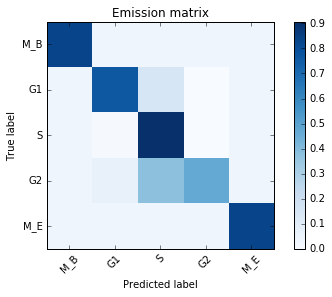

In [11]:
EmissionMat_=EmissionMat(model_1,model_n_m)
%Rpush EmissionMat_

### Preparing the training data to infer different parameters in the hidden markov chain

In [105]:
H2B_N_F_0,data=prep_for_R(H2B_N_F_0,
           classif_3state=classif_3state,
           classif_final=classif_final,
           classif_Mitose=classif_Mitose,
           num_str=num_str)

%Rpush data

data.head()


 We prioritize our predictor of mitosis events before the 3 state classfier giving 
 us a four state classifier. 

Frequency of predicted values for the 4 state classifier: 

1    14993
S    12710
2     1232
M      879
Name: Pred_fusion, dtype: int64
Updated member Group_of_traj


,traj,0015_id_frame,Pred_fusion
400,0,5,1
473,0,6,2
546,0,7,2
620,0,8,2
694,0,9,2


### Preparing the mitocheck data

In [106]:
MitoCheck,data_Mito=prep_for_R(MitoCheck,
           classif_3state=classif_3state,
           classif_final=classif_final,
           classif_Mitose=classif_Mitose,
           num_str=num_str)

%Rpush data_Mito

data_Mito.head()


 We prioritize our predictor of mitosis events before the 3 state classfier giving 
 us a four state classifier. 

Frequency of predicted values for the 4 state classifier: 

1    15397
S     1826
2      654
M      625
Name: Pred_fusion, dtype: int64
Updated member Group_of_traj


,Well,traj,Frame,Pred_fusion
12861,015,135,1,2
12865,015,135,2,2
12871,015,135,3,2
12879,015,135,4,2
12891,015,135,5,2


In [107]:
data_Mito[classif_final].value_counts()

2    15397
3     1826
4      654
5      376
1      249
Name: Pred_fusion, dtype: int64

## Working under R
### Inferering transProbs

In [108]:
%%R 
source("HMM_correcting_model.R")
list_obj=HMM_correct(data,EmissionMat_,classif_final,obs_number=0)
data=list_obj$new_data
mean_t=list_obj$mean_t
var_t=list_obj$var_t
mean_e=list_obj$mean_e
var_e=list_obj$var_e
transProbs=list_obj$transProbs

[1] "We are here going to correct the data predicted in the first part  \n         with a hidden markov where we infere the transition matrix with a \n         strong prior knowlegde in biology. A five state classifier :"
[1] "M_E -> G1 -> S -> G2 -> M_E"
[1] "To assess briefly what is happening, we printed a sequence of observation, sequence number: 0"
  [1] 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 [38] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 3 3 3 2 3 3 3 2 2
 [75] 2 2 3 3 3 3 3 2 3 3 2 3 3 3 3 2 2 2 3 3 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
[112] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 3 4 3 3 3 4 3 3 3 3 3 4
[149] 3 3 3 3 3 3 3 3 4 3 3 4 4 3 3 3 3 3 4 3 3 4 3 4 3 3 4 4 4 4 4 3 5 5 5 5 5
Levels: 1 2 3 4 5
[1] "To assess briefly what is happening, we printed the corrected sequence, number: 0"
  [1] 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 [38] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 

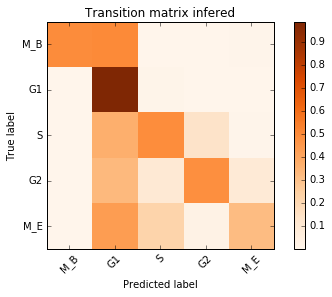

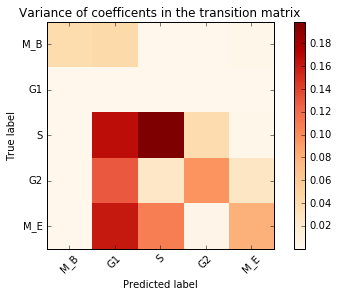

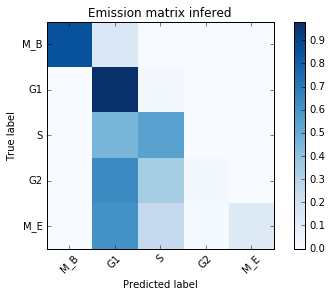

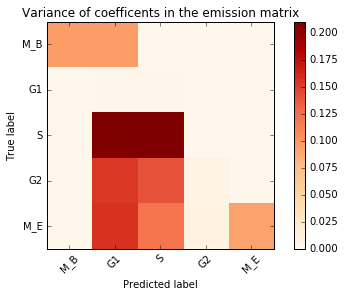

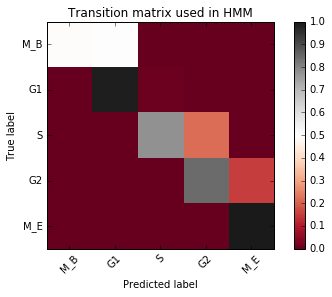

In [109]:
%Rpull mean_t mean_e var_t var_e transProbs data

plot_matrix(mean_t,title="Transition matrix infered",names=["M_B","G1","S","G2","M_E"],cmap=plt.cm.Oranges)
plt.show()
plot_matrix(var_t,title="Variance of coefficents in the transition matrix",names=["M_B","G1","S","G2","M_E"],cmap=plt.cm.OrRd)
plt.show()
plot_matrix(mean_e,title="Emission matrix infered",names=["M_B","G1","S","G2","M_E"])
plt.show()
plot_matrix(var_e,title="Variance of coefficents in the emission matrix",names=["M_B","G1","S","G2","M_E"],cmap=plt.cm.OrRd)
plt.show()
plot_matrix(transProbs,title="Transition matrix used in HMM",names=["M_B","G1","S","G2","M_E"],cmap=plt.cm.RdGy)
plt.show()


In [110]:
%%R
data_Mito=Predict_from_hmm(data_Mito,classif_final,classif_hmm,transProbs,EmissionMat_,startProbs)

[1] "To assess briefly what is happening, we printed the corrected sequence, number: 0"
 [1] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 5
Levels: 1 2 3 4 5 nan
 [1] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
[1] "Only nan's here...id:"
[1] "7387"


In [124]:
MitoCheck.data=MitoCheck.data.drop("HMM",axis=1)

In [125]:
%Rpull data_Mito
execfile('auxilary_function.py')
MitoCheck,res=final_classif_HMM(data_Mito,MitoCheck,
                  y_name_3state=y_name_3state,classif_Mitose=classif_Mitose,
                  classif_3state=classif_3state,classif_final=classif_final,
                              classif_hmm=classif_hmm,
                             ratio=0.5)

Here we are going to join the corrected data (from R) to our current data in Python 
 
Updated member Group_of_traj
We are going to count the lengths of the G1 phase, the S phase and the G2 phase: 

To quickly asses we print the trajectory and his corrected trajectory, for sequence number:0
Pred_fusion: 

['1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1'
 '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' 'E']

 Corrected HMM: 

['1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1'
 '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1']
> /home/pubuntu/Documents/InternWork2/auxilary_function.py(242)final_classif_HMM()
-> G1_p=[el*ratio for el in G1 if el>-1]
(Pdb) c
> /home/pubuntu/Documents/InternWork2/auxilary_function.py(247)final_classif_HMM()
-> res = {'mean' : pd.Series([np.mean(G1_p), np.mean(S_p), np.mean(G2_p),np.mean(CC_p)], index=['G1', 'S', 'G2','CellCycle']),
(Pdb) G1_p
[7.5, 28.5, 10.0, 11.0, 14.0, 7.5, 11.5, 13

In [126]:
res

,Accepted trajectories,Standard deviation,mean
G1,60,6.759047,11.583333
S,50,3.824252,6.010000
G2,50,5.123719,5.150000
CellCycle,50,5.853418,21.650000
